In [1]:
from PIL import Image
from src import depth_pro
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

c:\Users\moona\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
yolo_model = YOLO(r'C:\Users\moona\Desktop\Airun\best_qadam_02.pt')

In [3]:
image_path = r'C:\Users\moona\Desktop\Airun\photo_9_2024-10-23_02-01-59.jpg'

In [4]:
yolo_input = cv2.imread(image_path)
results = yolo_model.predict(yolo_input)


0: 640x480 2 Human_walkways, 1 car, 4 humans, 2 roads, 2 scooters, 719.0ms
Speed: 11.0ms preprocess, 719.0ms inference, 36.0ms postprocess per image at shape (1, 3, 640, 480)


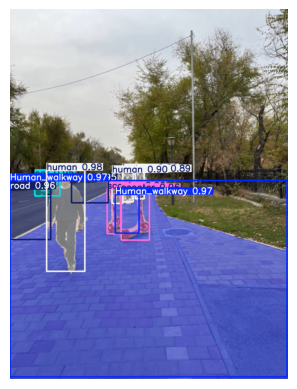

In [5]:
annotated_image = results[0].plot()  # Adjust this line based on your model's API

# Convert BGR (OpenCV) to RGB (matplotlib)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes
plt.show()

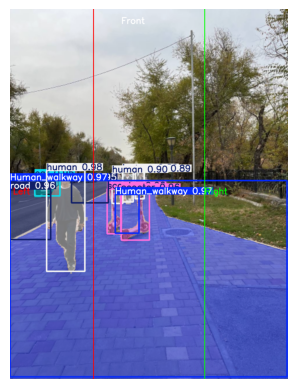

In [6]:
import cv2
import matplotlib.pyplot as plt

# Пример изображения с аннотациями
annotated_image = results[0].plot()  # Используйте результат вашей модели

# Конвертировать BGR (OpenCV) в RGB (matplotlib)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Добавить линии и текстовые метки
height, width, _ = annotated_image.shape

# Координаты для линий
left_line_start = (int(width * 0.3), 0)
left_line_end = (int(width * 0.3), height)

right_line_start = (int(width * 0.7), 0)
right_line_end = (int(width * 0.7), height)

# Рисуем линии
cv2.line(annotated_image, left_line_start, left_line_end, color=(255, 0, 0), thickness=2)
cv2.line(annotated_image, right_line_start, right_line_end, color=(0, 255, 0), thickness=2)

# Добавить текстовые метки
cv2.putText(annotated_image, 'Left', (10, int(height / 2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2.putText(annotated_image, 'Front', (int(width * 0.4), 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(annotated_image, 'Right', (int(width * 0.7), int(height / 2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Показать изображение с matplotlib
plt.imshow(annotated_image)
plt.axis('off')  # Скрыть оси
plt.show()


In [7]:
my_obj_boxes = []
classes_side = {}
annotated_image = results[0].plot() 
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
height, width, _ = annotated_image.shape
left = int(width * 0.3)
right = int(width * 0.7)

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    
    for box, cls in zip(boxes, classes):
        if (result.names[int(cls)] == 'human') | (result.names[int(cls)] == 'scooter') | (result.names[int(cls)] == 'car'):
            x1, y1, x2, y2 = map(int, box[:4])
            if ((x1 > left) and (x1 < right)) or ((x2 > left) and (x2 < right)):
                print(result.names[int(cls)])
                my_obj_boxes.append((x1, y1, x2, y2))
                cv2.rectangle(yolo_input, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2.imshow('My object Detection', yolo_input)
cv2.waitKey(0)
cv2.destroyAllWindows()

scooter
scooter
human
human
human


In [ ]:
# my_obj_boxes = []
# classes_side = {}
# for result in results:
#     boxes = result.boxes.xyxy.cpu().numpy()
#     classes = result.boxes.cls.cpu().numpy()
    
#     for box, cls in zip(boxes, classes):
#         if (result.names[int(cls)] == 'human') | (result.names[int(cls)] == 'scooter') | (result.names[int(cls)] == 'car'):
#             x1, y1, x2, y2 = map(int, box[:4])
#             my_obj_boxes.append((x1, y1, x2, y2))
#             cv2.rectangle(yolo_input, (x1, y1), (x2, y2), (0, 255, 0), 2)

# cv2.imshow('My object Detection', yolo_input)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# depth_and_cls = {}

In [9]:
depth_model, transform = depth_pro.create_model_and_transforms()
depth_model.eval()

image, _, f_px = depth_pro.load_rgb(image_path)
depth_input = transform(image)

prediction = depth_model.infer(depth_input, f_px=f_px)
depth = prediction["depth"]

depth_np = depth.squeeze().cpu().numpy()

for x1, y1, x2, y2 in my_obj_boxes:
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    
    depth_value = depth_np[center_y, center_x]
    
    text = f"Depth: {depth_value:.2f}m"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.2
    font_thickness = 2
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    
    text_x = x1
    text_y = y1 - 10
    rect_x1 = text_x - 5
    rect_y1 = text_y - text_size[1] - 10
    rect_x2 = text_x + text_size[0] + 5
    rect_y2 = text_y + 5
    
    cv2.rectangle(yolo_input, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 0), -1)
    cv2.putText(yolo_input, text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
    
    
cv2.imshow("Object Detection with Depth", yolo_input)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
cv2.imwrite('object_detection_with_depth.jpg', yolo_input)

True

In [ ]:
# depth_np_normalized = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min())
# inv_depth_np_normalized = 1.0 - depth_np_normalized
# depth_colormap = cv2.applyColorMap((inv_depth_np_normalized * 255).astype(np.uint8), cv2.COLORMAP_TURBO)
# cv2.imshow("Inverted Depth Map", depth_colormap)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [21]:
print(f"Min depth: {depth_np.min()}")
print(f"Max depth: {depth_np.max()}")


Min depth: 2.149441719055176
Max depth: 10000.0


In [18]:
# Обрезаем значения глубины в пределах от минимального до 10 метров
depth_clipped = np.clip(depth_np, 2.149, 40)

# Нормализация значений глубины
depth_np_normalized = (depth_clipped - depth_clipped.min()) / (depth_clipped.max() - depth_clipped.min())

# Инвертируем значения и применяем цветовую карту
inv_depth_np_normalized = 1.0 - depth_np_normalized
depth_colormap = cv2.applyColorMap((inv_depth_np_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Можно попробовать и другие карты

# Отображение карты глубины
cv2.imshow("Inverted Depth Map", depth_colormap)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [19]:
cv2.imwrite('inverted_depth_map.jpg', depth_colormap)

True